<font size="5"><center> **Exercise 1 (Conditional generation of names)** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓


### Download the dataset

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2024-04-27 16:52:11--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.37, 99.86.38.72, 99.86.38.96, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2024-04-27 16:52:11 (63.7 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.tx

In [ ]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

# Load the data

In [ ]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1  # Plus EOS marker

########
def findFiles(path): return glob.glob(path)
########

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 18 ['Chinese', 'Polish', 'Italian', 'Japanese', 'German', 'Scottish', 'Vietnamese', 'Portuguese', 'French', 'Greek', 'Korean', 'Russian', 'Arabic', 'Irish', 'English', 'Czech', 'Spanish', 'Dutch']


#Define all the fuctions needed for training

In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Function to create a tensor representing the target line (sequence of characters)
def targetTensor(line):
    # Get the indexes of each letter in the line (except for the last one)
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    # Append the index for the end-of-string token
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

####################################################################################

criterion = nn.NLLLoss() # Negative Log Likelihood Loss because we use nn.LogSoftmax

learning_rate = 0.0005

def train(learning_rate, category_tensor, input_line_tensor, target_line_tensor):
    # Expand the dimensions of target_line_tensor to match the shape of output tensor
    target_line_tensor.unsqueeze_(-1)
    # Initialize the hidden state of the RNN
    hidden = rnn.initHidden()
    # Clear the gradients of the model parameters
    rnn.zero_grad()
    # Initialize the loss to zero
    loss = torch.Tensor([0])  # Alternatively, you can simply use loss = 0
    # Iterate over each character in the input line
    for i in range(input_line_tensor.size(0)):
        # Forward pass: Compute the output and update the hidden state
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        # Compute the loss for this time step using the criterion (usually NLLLoss)
        l = criterion(output, target_line_tensor[i])
        # Accumulate the loss
        loss += l
    # Backpropagate the gradients
    loss.backward()
    # Update the model parameters using gradient descent
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    # Return the final output and the average loss per character in the input line
    return output, loss.item() / input_line_tensor.size(0)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


#Define the functions needed for generation

In [ ]:
def sample(model, max_length, category,start_letter='A'):
    # Disable gradient tracking since we're only sampling
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        # Convert the start letter to a tensor
        input = inputTensor(start_letter)
        # Initialize the hidden state of the RNN
        hidden = model.initHidden()
        # Initialize the output name with the start letter
        output_name = start_letter

        # Iterate until maximum length is reached or end-of-sequence token is predicted
        for i in range(max_length):
            # Forward pass: Compute the output and update the hidden state
            output, hidden = model(category_tensor, input[0], hidden)
            # Get the index of the top predicted letter
            topv, topi = output.topk(1)
            topi = topi[0][0]
            # If the predicted letter is the end-of-sequence token, break
            if topi == n_letters - 1:
                break
            else:
                # Otherwise, append the predicted letter to the output name
                letter = all_letters[topi]
                output_name += letter
            # Prepare input for the next iteration (use the predicted letter)
            input = inputTensor(letter)

        # Return the generated name
        return output_name

def samples(model, max_length, category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(model, max_length,category, start_letter))

def generate(model,all_categories, max_length = 10):
  print('Names Generation\n')
  for category in all_categories:
    print('===>',category,'Surnames starting from ABCDEFGKMN:')
    samples(model,max_length, category,'ABCDEFGKMN')

#Define and Train the RNN model

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Define input to hidden layer
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)  # input_size + hidden_size because we concatenate input and hidden state
        # Define input to output layer
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        # Define output to output layer
        self.o2o = nn.Linear(hidden_size + output_size, output_size)  # hidden_size + output_size because we concatenate hidden state and output
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.1)  # 10% dropout probability
        # Softmax layer to convert output into probabilities
        self.softmax = nn.LogSoftmax(dim=1)  # LogSoftmax along the output dimension ( first dimension typically represents the batch size). LogSoftmax --> numerical stability

    def forward(self, category, input, hidden):
        # Concatenate input and hidden state
        input_combined = torch.cat((category, input, hidden), 1)
        # Compute hidden state
        hidden = self.i2h(input_combined)
        # Compute output based on input and hidden state
        output = self.i2o(input_combined)
        # Concatenate hidden state and output
        output_combined = torch.cat((hidden, output), 1)
        # Compute final output
        output = self.o2o(output_combined)
        # Apply dropout to the output
        output = self.dropout(output)
        # Apply softmax to convert output into probabilities
        output = self.softmax(output)
        return output, hidden

    # Initialize hidden state with zeros
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


0m 22s (5000 5%) 3.4173
0m 44s (10000 10%) 2.5456
1m 5s (15000 15%) 3.1373
1m 25s (20000 20%) 2.9670
1m 46s (25000 25%) 2.9034
2m 7s (30000 30%) 2.1736
2m 27s (35000 35%) 3.0835
2m 48s (40000 40%) 2.2521
3m 10s (45000 45%) 2.6697
3m 30s (50000 50%) 2.6220
3m 51s (55000 55%) 2.5180
4m 11s (60000 60%) 2.6762
4m 33s (65000 65%) 1.6451
4m 54s (70000 70%) 2.4336
5m 16s (75000 75%) 2.3039
5m 37s (80000 80%) 0.9181
5m 57s (85000 85%) 2.7754
6m 18s (90000 90%) 3.5630
6m 39s (95000 95%) 2.0421
6m 59s (100000 100%) 1.6337


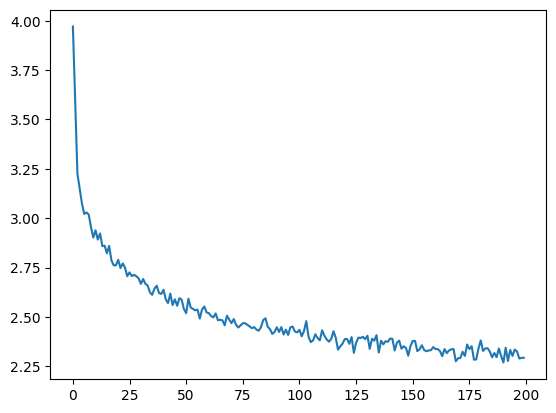

In [ ]:
rnn = RNN(n_letters, 256, n_letters)

learning_rate = 5e-4
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses_rnn = []
total_loss_rnn = 0

start = time.time()

for iter in range(1, n_iters + 1):
    # output, loss = train(*randomTrainingExample())
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
    output, loss = train(learning_rate, category_tensor, input_line_tensor, target_line_tensor)
    total_loss_rnn += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_rnn.append(total_loss_rnn / plot_every)
        total_loss_rnn = 0

plt.figure()
plt.plot(all_losses_rnn)

#Generate diffent names with RNN

In [ ]:
generate(rnn, all_categories)

Names Generation

===> Chinese Surnames starting from ABCDEFG:
Ang
Ban
Chon
Dung
Eun
Fan
Gung
Kou
Man
Nan
===> Polish Surnames starting from ABCDEFG:
Allon
Bosko
Coskel
Dosko
Eosko
Fallak
Goske
Kosel
Malloskk
Nakel
===> Italian Surnames starting from ABCDEFG:
Allin
Barin
Carison
Dongali
Eangano
Farton
Garin
Kangeri
Marini
Nangali
===> Japanese Surnames starting from ABCDEFG:
Angou
Banaka
Chama
Danaka
Eaka
Fanama
Gamana
Kamaka
Maki
Naka
===> German Surnames starting from ABCDEFG:
Alleng
Berner
Cherren
Derren
Eres
Farter
Gerren
Kerr
Maren
Namer
===> Scottish Surnames starting from ABCDEFG:
Allen
Banger
Cherson
Dangell
Eringel
Fallen
Ganders
Kandel
Mallon
Nander
===> Vietnamese Surnames starting from ABCDEFG:
Ang
Ban
Chan
Du
Eun
Fa
Gu
Koun
Man
Na
===> Portuguese Surnames starting from ABCDEFG:
Artan
Bareser
Candero
Dongaro
Eers
Farras
Garra
Kares
Mares
Narer
===> French Surnames starting from ABCDEFG:
Aller
Baller
Cares
Derrin
Eellert
Farren
Goure
Kares
Merrier
Nares
===> Greek Surnames s

#Train with LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size + n_categories, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        combined = torch.cat((category, input), 1)
        output, hidden = self.lstm(combined.unsqueeze(0), hidden)
        output = self.out(output.squeeze(0))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))


0m 32s (5000 5%) 3.0525
1m 6s (10000 10%) 2.9897
1m 39s (15000 15%) 2.1625
2m 11s (20000 20%) 2.1234
2m 45s (25000 25%) 2.6690
3m 17s (30000 30%) 1.7423
3m 50s (35000 35%) 1.2363
4m 23s (40000 40%) 2.8040
4m 55s (45000 45%) 2.1471
5m 28s (50000 50%) 2.0770
6m 0s (55000 55%) 1.9454
6m 33s (60000 60%) 2.8637
7m 6s (65000 65%) 2.5899
7m 38s (70000 70%) 1.3126
8m 12s (75000 75%) 2.0412
8m 45s (80000 80%) 1.5379
9m 18s (85000 85%) 1.5983
9m 51s (90000 90%) 1.8564
10m 23s (95000 95%) 2.8962
10m 56s (100000 100%) 1.6989


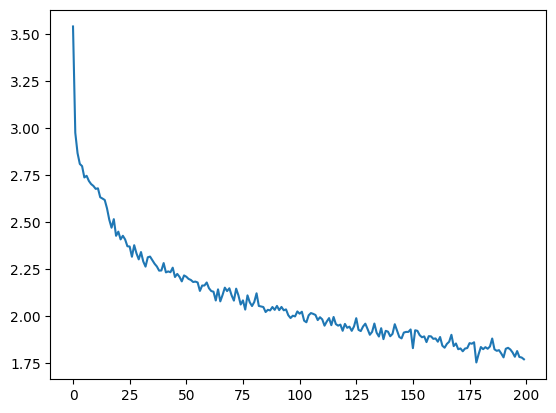

In [ ]:
rnn = LSTM(n_letters, 64, n_letters)

learning_rate = 5e-3
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses_lstm = []
total_loss_lstm = 0

start = time.time()

for iter in range(1, n_iters + 1):
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
    output, loss = train(learning_rate, category_tensor, input_line_tensor, target_line_tensor)

    total_loss_lstm += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_lstm.append(total_loss_lstm / plot_every)
        total_loss_lstm = 0

plt.figure()
plt.plot(all_losses_lstm)

#Generate names with LSTM



In [ ]:
generate(rnn,all_categories)

Names Generation

===> Chinese Surnames starting from ABCDEFG:
Ang
Bang
Chu
Duan
Eng
Fing
Guan
Kuan
Ming
Nian
===> Polish Surnames starting from ABCDEFG:
Aldez
Basko
Colowski
Dozek
Esterski
Francki
Grozkowski
Kowski
Malowski
Nistek
===> Italian Surnames starting from ABCDEFG:
Abari
Barco
Carto
Dellano
Engini
Fertino
Garco
Kanto
Machi
Nacci
===> Japanese Surnames starting from ABCDEFG:
Anama
Basaka
Chimama
Dugama
Eshima
Famata
Garasa
Kamata
Mataka
Nasaka
===> German Surnames starting from ABCDEFG:
Arter
Berter
Cherer
Denger
Enger
Ferter
Greiner
Kenter
Marter
Neiner
===> Scottish Surnames starting from ABCDEFG:
Alleron
Brang
Chamer
Duchan
Engeson
Frang
Grang
Krang
Mcchon
Nisson
===> Vietnamese Surnames starting from ABCDEFG:
Ang
Buang
Chu
Duang
En
Fuang
Guang
Kuung
Man
Nang
===> Portuguese Surnames starting from ABCDEFG:
Arros
Barros
Cartos
Delveiro
Erauro
Ferreira
Garra
Karria
Maria
Nastes
===> French Surnames starting from ABCDEFG:
Alberte
Barcher
Chare
Deveron
Ester
Ferter
Garder
Kare

# Train with GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size + n_categories, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_cat = torch.cat((input, category), 1)
        output, hidden = self.gru(input_cat.unsqueeze(0), hidden)
        output = self.linear(output.squeeze(0))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)


0m 25s (5000 5%) 1.8845
0m 50s (10000 10%) 1.9227
1m 14s (15000 15%) 2.4384
1m 42s (20000 20%) 1.1948
2m 7s (25000 25%) 2.4026
2m 33s (30000 30%) 2.1048
2m 58s (35000 35%) 2.4517
3m 23s (40000 40%) 1.6919
3m 47s (45000 45%) 2.1680
4m 11s (50000 50%) 2.6200
4m 38s (55000 55%) 2.4122
5m 2s (60000 60%) 1.6450
5m 26s (65000 65%) 1.6321
5m 51s (70000 70%) 2.1569
6m 14s (75000 75%) 1.7880
6m 38s (80000 80%) 2.0694
7m 3s (85000 85%) 2.4390
7m 27s (90000 90%) 1.9840
7m 51s (95000 95%) 2.1550
8m 15s (100000 100%) 1.0514


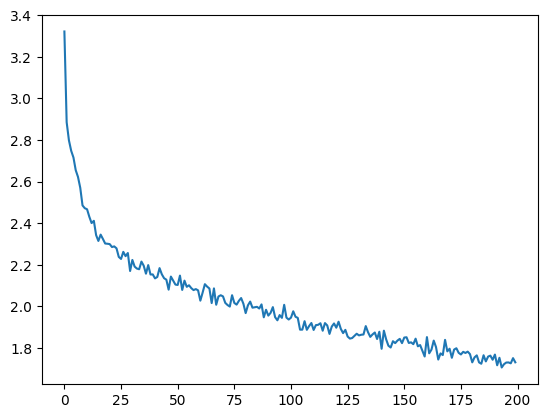

In [ ]:
rnn = GRU(n_letters, 64, n_letters)

learning_rate = 5e-3
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses_gru = []
total_loss_gru = 0

start = time.time()

for iter in range(1, n_iters + 1):
    # output, loss = train(*randomTrainingExample())
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
    output, loss = train(learning_rate, category_tensor, input_line_tensor, target_line_tensor)
    total_loss_gru += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_gru.append(total_loss_gru / plot_every)
        total_loss_gru = 0

plt.figure()
plt.plot(all_losses_gru)

#Generate names with GRU

In [ ]:
generate(rnn,all_categories)

Names Generation

===> Chinese Surnames starting from ABCDEFG:
Ang
Bang
Che
Deng
Eg
Feng
Gue
Kang
Man
Nian
===> Polish Surnames starting from ABCDEFG:
Alamin
Bazzak
Cosko
Duzak
Ezkowski
Fiennek
Gienka
Kosko
Marski
Nienki
===> Italian Surnames starting from ABCDEFG:
Alberi
Barco
Campo
Deverti
Essano
Ferri
Garco
Karono
Marchi
Namino
===> Japanese Surnames starting from ABCDEFG:
Ashima
Bashima
Chimata
Damaka
Eshima
Farama
Gakaka
Kamashi
Maka
Nakaka
===> German Surnames starting from ABCDEFG:
Almer
Bern
Cher
Denger
Esser
Fern
Grenn
Koher
Mass
Neiser
===> Scottish Surnames starting from ABCDEFG:
Aller
Brand
Chert
Duch
Ellin
Frand
Graman
Konghald
Mccallon
Nicher
===> Vietnamese Surnames starting from ABCDEFG:
Agh
Banh
Chu
Duan
Eg
Fuang
Guang
Kan
Ma
Na
===> Portuguese Surnames starting from ABCDEFG:
Arteira
Basca
Castro
Denra
Esteiro
Ferreiro
Garras
Kourro
Mares
Nasero
===> French Surnames starting from ABCDEFG:
Allance
Berre
Coure
Dever
Esser
Ferre
Garchard
Kauve
Marte
Never
===> Greek Surna